In [1]:
import torch
import pandas as pd
import numpy as np
import lovely_tensors as lt

lt.monkey_patch()

In [2]:
!gdown 1-2Jz6QSQ4tqXRM6eDRhcMiffU6GA04_9

Downloading...
From: https://drive.google.com/uc?id=1-2Jz6QSQ4tqXRM6eDRhcMiffU6GA04_9
To: /app/notebooks/secchi_depth1.nc
100%|█████████████████████████████████████████| 622M/622M [00:02<00:00, 214MB/s]


In [2]:
import netCDF4 as nc
import xarray as xr

In [3]:
DS = xr.open_dataset('/app/notebooks/secchi_depth1.nc')
df = DS.to_dataframe().reset_index()

In [4]:
df['is_na'] = df['ZSD'].isna()

In [5]:
df['norm_ZSD'] = df['ZSD'] / df['ZSD'].max()
df

,time,lat,lon,KD490,ZSD_uncertainty,KD490_uncertainty,flags,ZSD,is_na,norm_ZSD
0,2022-01-31,62.020832,-12.020828,NaN,NaN,NaN,0,NaN,True,NaN
1,2022-01-31,62.020832,-11.979161,NaN,NaN,NaN,0,NaN,True,NaN
2,2022-01-31,62.020832,-11.937495,NaN,NaN,NaN,0,NaN,True,NaN
3,2022-01-31,62.020832,-11.895828,NaN,NaN,NaN,0,NaN,True,NaN
4,2022-01-31,62.020832,-11.854161,NaN,NaN,NaN,0,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...,...
47875900,2023-02-03,48.020832,3.812505,NaN,NaN,NaN,1,NaN,True,NaN
47875901,2023-02-03,48.020832,3.854172,NaN,NaN,NaN,1,NaN,True,NaN
47875902,2023-02-03,48.020832,3.895839,NaN,NaN,NaN,1,NaN,True,NaN
47875903,2023-02-03,48.020832,3.937505,NaN,NaN,NaN,1,NaN,True,NaN


In [6]:
defaut_nans_n = df[df['time'] == '2022-02-05']['norm_ZSD'].isna().sum()
defaut_nans_n

33659

In [7]:
defaut_nans_n * 1.1

37024.9

In [8]:
nnans_df = df[['time', 'is_na']].groupby('time').sum().reset_index()
nnans_df = nnans_df[nnans_df['is_na'] < int(defaut_nans_n * 1.1)]
valid_dates = nnans_df.time

In [9]:
valid_df = df[df.time.isin(valid_dates)]

In [10]:
# Transform pandas to tensor
def raw2tensor(df):
    lon_arr = df['lon'].unique()
    lat_arr = df['lat'].unique()
    time_arr = df['time'].unique()
    
    lon_ids = {}
    lat_ids = {}
    time_ids = {}
    for i, lon in enumerate(lon_arr):
        lon_ids[lon] = i
    for i, lat in enumerate(lat_arr):
        lat_ids[lat] = i
    for i, date in enumerate(time_arr):
        time_ids[str(date)[:10]] = i
    df['x'] = df['lat'].apply(lambda x: lat_ids[x])
    df['y'] = df['lon'].apply(lambda x: lon_ids[x])
    df['d'] = df['time'].apply(lambda x: time_ids[str(x)[:10]])
    
    x_img = np.zeros((df.d.max()+1, df.x.max()+1, df.y.max()+1))
    x_img[df.d, df.x, df.y] = df.ZSD
    
    zsd_tensor = torch.tensor(x_img).unsqueeze(1)
    return zsd_tensor

In [11]:
zsd_tensor = raw2tensor(valid_df)

/tmp/ipykernel_3989/4149599675.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = df['lat'].apply(lambda x: lat_ids[x])
/tmp/ipykernel_3989/4149599675.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['lon'].apply(lambda x: lon_ids[x])
/tmp/ipykernel_3989/4149599675.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [12]:
torch.save(zsd_tensor, '/app/data/zsd_tensor.pt')

In [125]:
zsd_tensor[0]

tensor[1, 337, 385] f64 n=129745 x∈[0.031, 0.810] μ=0.350 σ=0.184 NaN!

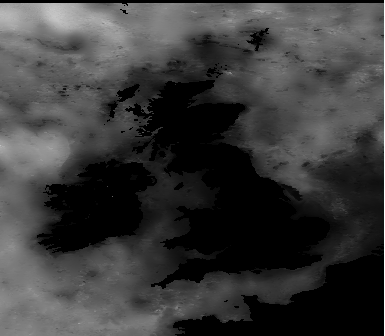

In [128]:
zsd_tensor[-1].expand((3, 337, 385))[:,:,:].rgb

In [130]:
H, W = zsd_tensor.shape[2:]
H, W

(337, 385)

In [129]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
fps=30

out_video_path = 'sea_depth1.mp4'

frames = [(f.expand(3, H, W).permute(1,2,0).numpy() * 255).astype(np.uint8) for f in zsd_tensor]

clip = clip =ImageSequenceClip(frames, fps=fps)
clip.write_videofile(out_video_path, fps=fps)

Moviepy - Building video sea_depth1.mp4.
Moviepy - Writing video sea_depth1.mp4



Moviepy - Done !
Moviepy - video ready sea_depth1.mp4
